<a href="https://colab.research.google.com/github/bominwang/inviscid-viscid-flow-correct-neural-network/blob/HB-2-surface-pressure/HB_2_SURFACE_PRESSURE_PRED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

无粘网络构建

In [51]:
# 加载谷歌云盘
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# 加载相应模块
import time
import pandas as pd
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD
from torch.autograd import Variable 
import matplotlib.pyplot as plt
import tqdm
from tqdm import trange

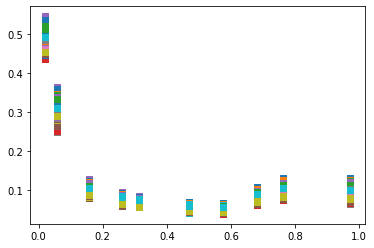

In [53]:
# 加载数据集
ins = pd.read_csv('drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_input_data.csv')
ins = np.array(ins)
labs = pd.read_csv('drive/MyDrive/Colab Notebooks/bm_wang/data/HB2/inv/inv_output_data.csv')
labs = np.array(labs)
positions = labs[:,0].reshape(-1,10)
labs = labs[:,1].reshape(-1,10)
data_size = np.size(labs,0)
# 样本展示
for i in range(data_size):
  position = positions[i, :]
  lab = labs[i, :]
  plt.plot(position, lab, 's')


In [54]:
# 构建训练数据集
train_data_ins = torch.from_numpy(ins[0:150, :])
train_data_labs = torch.from_numpy(labs[0:150, :])

test_data_ins = torch.from_numpy(ins[150:201, :])
test_data_labs = torch.from_numpy(labs[150:201, :])

train_set = TensorDataset(train_data_ins, train_data_labs)
train_set = DataLoader(train_set, batch_size = 150, shuffle = True)

# test_set = TensorDataset(test_data_ins, test_data_labs)
# test_set = DataLoader(test_set,  batch_size = 50, shuffle = True)

In [55]:
# 构建网络结构
class inviscid_nn(nn.Module):
  def __init__(self) -> None:
    super(inviscid_nn, self).__init__()

    self.hidden_layer1 = nn.Sequential(
        nn.Linear(2, 100),
        nn.Dropout(0.5),
        #nn.BatchNorm1d(100),
        nn.ReLU()
    )
    self.hidden_layer2 = nn.Sequential(
        nn.Linear(100, 300),
        #nn.BatchNorm1d(300),
        nn.ReLU()
    )
    self.output_layer = nn.Sequential(
        nn.Linear(300, 10)
    )
  def forward(self, x):
    x = self.hidden_layer1(x)
    x = self.hidden_layer2(x)
    y = self.output_layer(x)
    return y

# 实例化无粘网络
inviscid_model = inviscid_nn()

100%|██████████| 2500/2500 [00:08<00:00, 303.72it/s]



无粘网络训练损失函数收敛于0.004800288937985897

无粘网络测试集损失函数收敛于0.004551816266030073


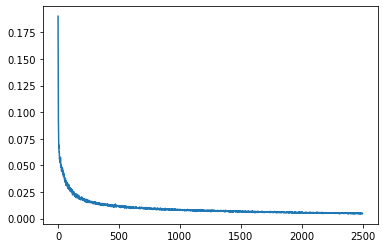

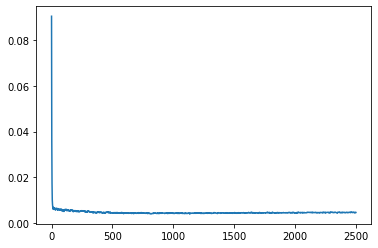

In [56]:
# 训练无粘网络
optimizer = SGD(inviscid_model.parameters(), lr = 0.01)
loss_function = nn.SmoothL1Loss()

train_loss_history = []
test_loss_history = []

for epoch in trange(2500):
  for index,(ins, lab) in enumerate(train_set):
        ins = Variable(ins).reshape(-1,2).to(torch.float32)
        lab = Variable(lab).reshape(-1,10).to(torch.float32)
        # 反向传播
        inviscid_model.train()
        pred = inviscid_model(ins)
        loss = loss_function(pred, lab)
        train_loss_history.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 测试集误差
        inviscid_model.eval()
        pred = inviscid_model(test_data_ins.reshape(-1,2).to(torch.float32))
        loss = loss_function(pred, test_data_labs.reshape(-1,10).to(torch.float32))
        test_loss_history.append(loss.item())
plt.figure(2)
plt.plot(train_loss_history)
print(f'\n无粘网络训练损失函数收敛于{train_loss_history[-1]}')
plt.figure(3)
plt.plot(test_loss_history)
print(f'\n无粘网络测试集损失函数收敛于{test_loss_history[-1]}')

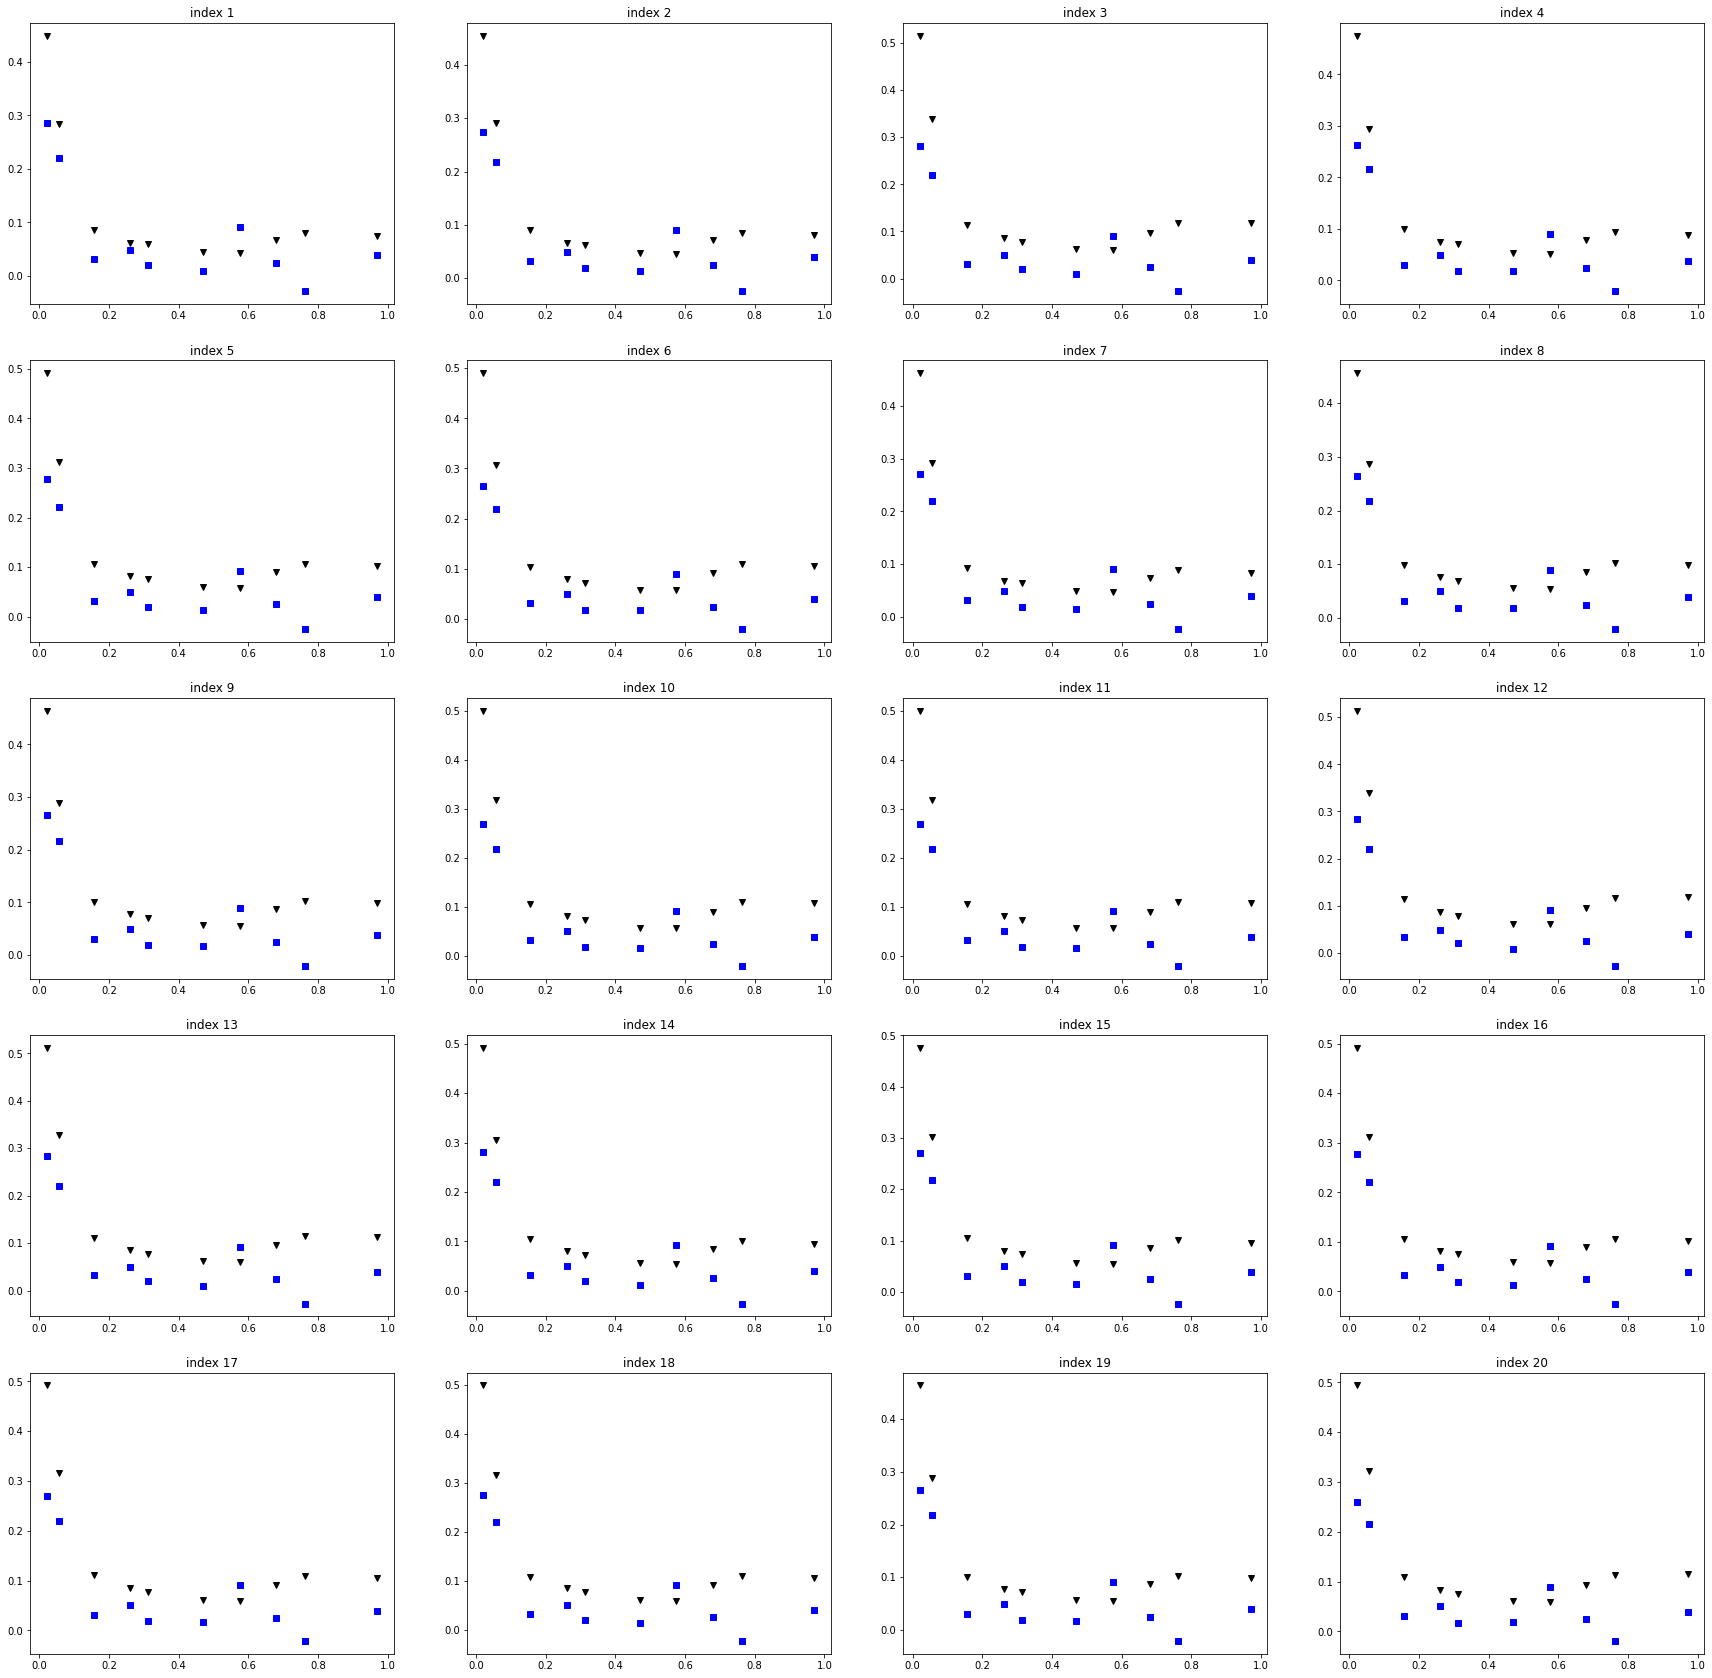

In [57]:
# 输出合理性验证
# 黑色为试验数据
# 蓝色为网络预测数据
inviscid_model.eval()
position = torch.from_numpy(positions[1, :]).reshape(1,10)
index = torch.randint(0, 50, [20,1])
val_ins = test_data_ins[index, :]
val_labs = test_data_labs[index, :]
val_pred = inviscid_model(val_ins.reshape(-1, 2).to(torch.float32))
plt.figure(figsize=(30, 30))
fig1 = plt.subplot(5, 4, 1)
plt.plot(position, val_labs[0, :],'kv')
plt.plot(position, val_pred[0, :].reshape(1,10).detach().numpy(),'bs')
fig1.set_title('index 1')
fig2 = plt.subplot(5, 4, 2)
plt.plot(position, val_labs[1, :],'kv')
plt.plot(position, val_pred[1, :].reshape(1,10).detach().numpy(),'bs')
fig2.set_title('index 2')
fig3 = plt.subplot(5, 4, 3)
plt.plot(position, val_labs[2, :],'kv')
plt.plot(position, val_pred[2, :].reshape(1,10).detach().numpy(),'bs')
fig3.set_title('index 3')
fig4 = plt.subplot(5, 4, 4)
plt.plot(position, val_labs[3, :],'kv')
plt.plot(position, val_pred[3, :].reshape(1,10).detach().numpy(),'bs')
fig4.set_title('index 4')
fig5 = plt.subplot(5, 4, 5)
plt.plot(position, val_labs[4, :],'kv')
plt.plot(position, val_pred[4, :].reshape(1,10).detach().numpy(),'bs')
fig5.set_title('index 5')
fig6 = plt.subplot(5, 4, 6)
plt.plot(position, val_labs[5, :],'kv')
plt.plot(position, val_pred[5, :].reshape(1,10).detach().numpy(),'bs')
fig6.set_title('index 6')
fig7 = plt.subplot(5, 4, 7)
plt.plot(position, val_labs[6, :],'kv')
plt.plot(position, val_pred[6, :].reshape(1,10).detach().numpy(),'bs')
fig7.set_title('index 7')
fig8 = plt.subplot(5, 4, 8)
plt.plot(position, val_labs[7, :],'kv')
plt.plot(position, val_pred[7, :].reshape(1,10).detach().numpy(),'bs')
fig8.set_title('index 8')
fig9 = plt.subplot(5, 4, 9)
plt.plot(position, val_labs[8, :],'kv')
plt.plot(position, val_pred[8, :].reshape(1,10).detach().numpy(),'bs')
fig9.set_title('index 9')
fig10 = plt.subplot(5, 4, 10)
plt.plot(position, val_labs[9, :],'kv')
plt.plot(position, val_pred[9, :].reshape(1,10).detach().numpy(),'bs')
fig10.set_title('index 10')
fig11 = plt.subplot(5, 4, 11)
plt.plot(position, val_labs[10, :],'kv')
plt.plot(position, val_pred[10, :].reshape(1,10).detach().numpy(),'bs')
fig11.set_title('index 11')
fig12 = plt.subplot(5, 4, 12)
plt.plot(position, val_labs[11, :],'kv')
plt.plot(position, val_pred[11, :].reshape(1,10).detach().numpy(),'bs')
fig12.set_title('index 12')
fig13 = plt.subplot(5, 4, 13)
plt.plot(position, val_labs[12, :],'kv')
plt.plot(position, val_pred[12, :].reshape(1,10).detach().numpy(),'bs')
fig13.set_title('index 13')
fig14 = plt.subplot(5, 4, 14)
plt.plot(position, val_labs[13, :],'kv')
plt.plot(position, val_pred[13, :].reshape(1,10).detach().numpy(),'bs')
fig14.set_title('index 14') 
fig15 = plt.subplot(5, 4, 15)
plt.plot(position, val_labs[14, :],'kv')
plt.plot(position, val_pred[14, :].reshape(1,10).detach().numpy(),'bs')
fig15.set_title('index 15')
fig16 = plt.subplot(5, 4, 16)
plt.plot(position, val_labs[15, :],'kv')
plt.plot(position, val_pred[15, :].reshape(1,10).detach().numpy(),'bs')
fig16.set_title('index 16')
fig17 = plt.subplot(5, 4, 17)
plt.plot(position, val_labs[16, :],'kv')
plt.plot(position, val_pred[16, :].reshape(1,10).detach().numpy(),'bs')
fig17.set_title('index 17')
fig18 = plt.subplot(5, 4, 18)
plt.plot(position, val_labs[17, :],'kv')
plt.plot(position, val_pred[17, :].reshape(1,10).detach().numpy(),'bs')
fig18.set_title('index 18')
fig19 = plt.subplot(5, 4, 19)
plt.plot(position, val_labs[18, :],'kv')
plt.plot(position, val_pred[18, :].reshape(1,10).detach().numpy(),'bs')
fig19.set_title('index 19')
fig20 = plt.subplot(5, 4, 20)
plt.plot(position, val_labs[19, :],'kv')
plt.plot(position, val_pred[19, :].reshape(1,10).detach().numpy(),'bs')
fig20.set_title('index 20')
plt.show()